In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

2024-07-16 16:28:29.771608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 16:28:29.771722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 16:28:29.892187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Define dataset path and parameters
dataset_path = '/kaggle/input/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)/Fruits'
img_height, img_width = 224, 224
batch_size = 32
num_classes = 2  # Assuming 2 classes (folders)

class_names = ['FreshMango', 'RottenMango']  # Replace with actual class folder names

# Prepare lists for image file paths and labels
file_paths = []
labels = []

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)
    file_paths.extend([os.path.join(class_path, img) for img in images])
    labels.extend([class_name] * len(images))

# Convert labels to numerical values
label_to_index = {name: index for index, name in enumerate(class_names)}
numeric_labels = [label_to_index[label] for label in labels]


In [3]:
# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    file_paths, numeric_labels, test_size=0.3, random_state=42, stratify=numeric_labels)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

print(f"Number of training examples: {len(train_files)}")
print(f"Number of validation examples: {len(val_files)}")
print(f"Number of test examples: {len(test_files)}")

# Create TensorFlow datasets
def load_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    return image, label

train_ds1 = tf.data.Dataset.from_tensor_slices((train_files, train_labels)).map(load_image).batch(batch_size)
val_ds1 = tf.data.Dataset.from_tensor_slices((val_files, val_labels)).map(load_image).batch(batch_size)
test_ds1 = tf.data.Dataset.from_tensor_slices((test_files, test_labels)).map(load_image).batch(batch_size)


Number of training examples: 838
Number of validation examples: 180
Number of test examples: 180


In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),

])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Apply data augmentation to training dataset
train_ds2 = train_ds1.map(lambda x, y: (data_augmentation(x, training=True), y))

# Preprocess and scale images
train_ds = train_ds2.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds1.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input(x), y))


# MobileNetV2

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])


model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model and save history
history = model.fit(train_ds, batch_size=32,epochs=100,validation_data=val_ds, callbacks=[early_stopping])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
 3/27 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5608 - loss: 0.7516 

I0000 00:00:1720400530.119653     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 849ms/step - accuracy: 0.7658 - loss: 0.5003 - val_accuracy: 0.9944 - val_loss: 0.0848
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - accuracy: 0.9864 - loss: 0.1021 - val_accuracy: 1.0000 - val_loss: 0.0401
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 467ms/step - accuracy: 0.9882 - loss: 0.0615 - val_accuracy: 1.0000 - val_loss: 0.0274
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - accuracy: 0.9880 - loss: 0.0529 - val_accuracy: 1.0000 - val_loss: 0.0224
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 468ms/step - accuracy: 0.9862 - loss: 0.0476 - val_accuracy: 1.0000 - val_loss: 0.0179
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 462ms/step - accuracy: 0.9986 - loss: 0.0275 - val_accuracy: 1.0000 - val_loss: 0.0160
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - accuracy: 0.9981 - loss: 0.0268 - val_accuracy: 1.0000 - val_loss: 0.0162
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 463ms/step - accuracy: 0.9944 - loss: 0.0339 - val_accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9912 - loss: 0.0241
Test Accuracy: 0.9833333492279053
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

  FreshMango     0.9681    1.0000    0.9838        91
 RottenMango     1.0000    0.9663    0.9829        89

    accuracy                         0.9833       180
   macro avg     0.9840    0.9831    0.9833       180
weighted avg     0.9839    0.9833    0.9833       180



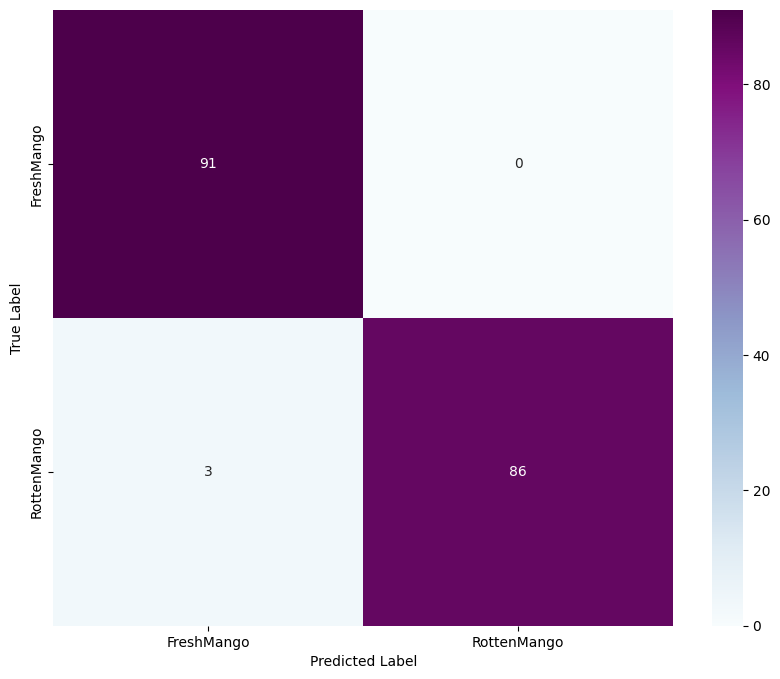

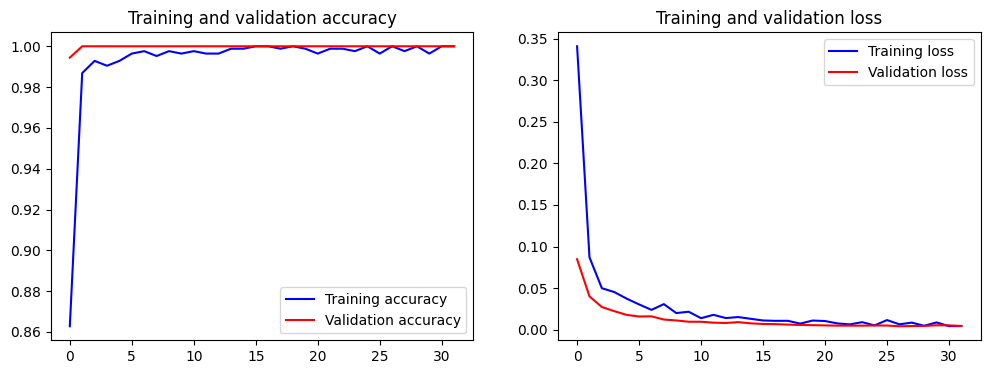

In [6]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# ResNet50

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential



# Preprocess input images for VGG16
def preprocess_input_resnet(x):
    x = tf.keras.applications.resnet.preprocess_input(x)
    return x

train_ds = train_ds2.map(lambda x, y: (preprocess_input_resnet(x), y))

val_ds = val_ds1.map(lambda x, y: (preprocess_input_resnet(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input_resnet(x), y))



# Load ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add layers on top of the base model
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes)

# Create the model
model = Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and save history
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/100
 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5122 - loss: 1.1969

I0000 00:00:1721147450.790068     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721147450.843642     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.6897 - loss: 0.6952

W0000 00:00:1721147469.410061     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 892ms/step - accuracy: 0.6940 - loss: 0.6858 - val_accuracy: 0.9889 - val_loss: 0.0926
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.9790 - loss: 0.1149 - val_accuracy: 1.0000 - val_loss: 0.0359
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 481ms/step - accuracy: 0.9915 - loss: 0.0535 - val_accuracy: 1.0000 - val_loss: 0.0243
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.9909 - loss: 0.0435 - val_accuracy: 1.0000 - val_loss: 0.0200
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 485ms/step - accuracy: 0.9935 - loss: 0.0438 - val_accuracy: 1.0000 - val_loss: 0.0145
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 486ms/step - accuracy: 0.9928 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 0.0100
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.9978 - loss: 0.0243 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 477ms/step - accuracy: 0.9947 - loss: 0.0209 - val_accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9902 - loss: 0.0546 
Test Accuracy: 0.9888888597488403
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

  FreshMango     0.9785    1.0000    0.9891        91
 RottenMango     1.0000    0.9775    0.9886        89

    accuracy                         0.9889       180
   macro avg     0.9892    0.9888    0.9889       180
weighted avg     0.9891    0.9889    0.9889       180



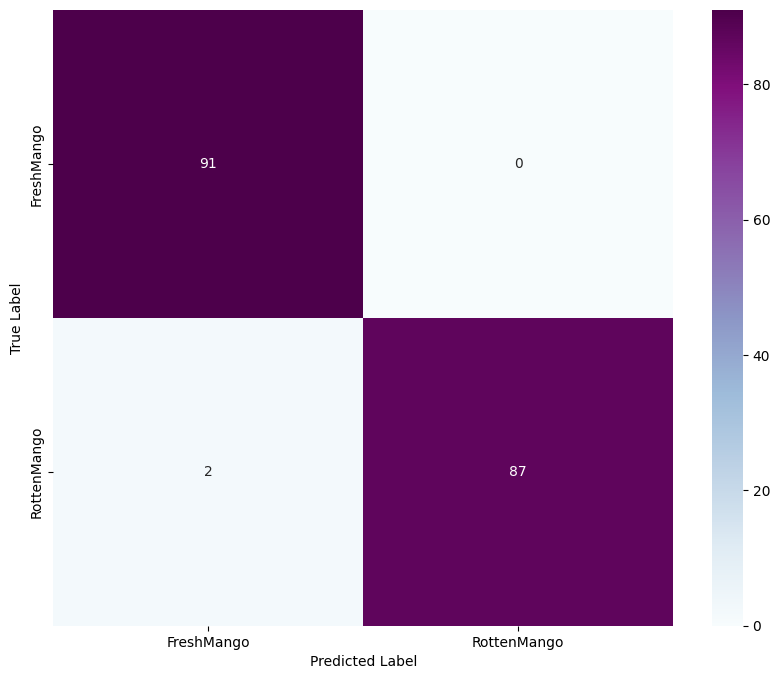

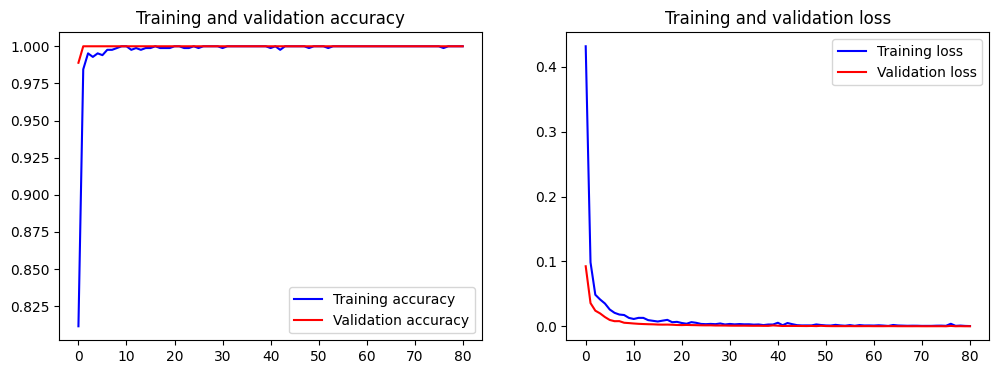

In [6]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# VGG16

In [9]:
from tensorflow.keras.applications import VGG16

# Preprocess input images for VGG16
def preprocess_input_vgg(x):
    x = tf.keras.applications.vgg16.preprocess_input(x)
    return x

train_ds = train_ds2.map(lambda x, y: (preprocess_input_vgg(x), y))

val_ds = val_ds1.map(lambda x, y: (preprocess_input_vgg(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input_vgg(x), y))


# Assuming you have defined img_height, img_width, num_classes, train_ds, and val_ds appropriately

# Load VGG16 model with pre-trained ImageNet weights
base_model = VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add layers on top of the base model
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes)

# Create the model
model = Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and save history
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


2024-07-08 01:23:28.055641: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-07-08 01:23:28.055709: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-07-08 01:23:28.055723: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-07-08 01:23:28.055734: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-07-08 01:23:28.055745: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-07-08 01:23:28.055757: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-07-08 01:23:28.055769: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-07-08 01:23:28.055781: E external/local_xla/xla/se

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6750 - loss: 2.8940

2024-07-08 01:23:53.712012: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.64217, expected 2.7931
2024-07-08 01:23:53.712063: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.85027, expected 4.0012
2024-07-08 01:23:53.712073: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.44079, expected 3.59172
2024-07-08 01:23:53.712081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.81156, expected 3.96248
2024-07-08 01:23:53.712088: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.0588, expected 4.20973
2024-07-08 01:23:53.712096: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.43719, expected 3.58812
2024-07-08 01:23:53.712104: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.55385, expected 3.70478
2024-07-08 01:23:53.712111: E external/local_xla/xla/servi

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6772 - loss: 3.5150

2024-07-08 01:23:59.835468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.79983, expected 3.15789
2024-07-08 01:23:59.835526: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.13466, expected 4.49272
2024-07-08 01:23:59.835540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 4.78155, expected 4.13961
2024-07-08 01:23:59.835554: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.88295, expected 4.24101
2024-07-08 01:23:59.835577: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.73279, expected 4.09085
2024-07-08 01:23:59.835590: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.69943, expected 4.05749
2024-07-08 01:23:59.835600: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.1975, expected 3.55556
2024-07-08 01:23:59.835611: 

27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6793 - loss: 4.0917 - val_accuracy: 0.7611 - val_loss: 2.8363
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 481ms/step - accuracy: 0.6795 - loss: 30.4547 - val_accuracy: 0.5556 - val_loss: 10.3661
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 473ms/step - accuracy: 0.6503 - loss: 11.3506 - val_accuracy: 0.7167 - val_loss: 2.8432
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 479ms/step - accuracy: 0.7772 - loss: 21.5239 - val_accuracy: 0.6778 - val_loss: 7.2087
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 475ms/step - accuracy: 0.7422 - loss: 12.8764 - val_accuracy: 0.7167 - val_loss: 3.4985
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 477ms/step - accuracy: 0.7763 - loss: 9.7801 - val_accuracy: 0.7444 - val_loss: 3.9888


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8250 - loss: 2.0596
Test Accuracy: 0.7833333611488342
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
              precision    recall  f1-score   support

  FreshMango     0.7600    0.8352    0.7958        91
 RottenMango     0.8125    0.7303    0.7692        89

    accuracy                         0.7833       180
   macro avg     0.7863    0.7828    0.7825       180
weighted avg     0.7860    0.7833    0.7827       180



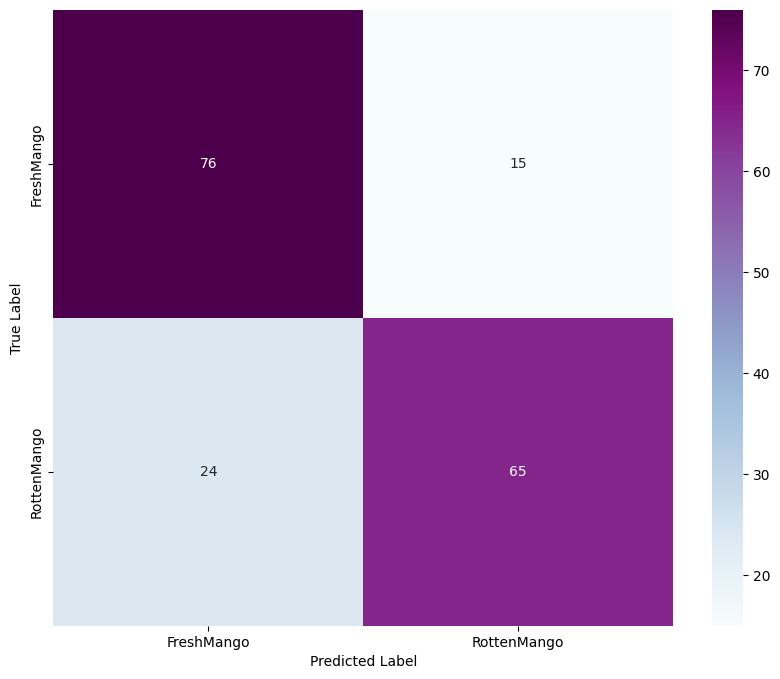

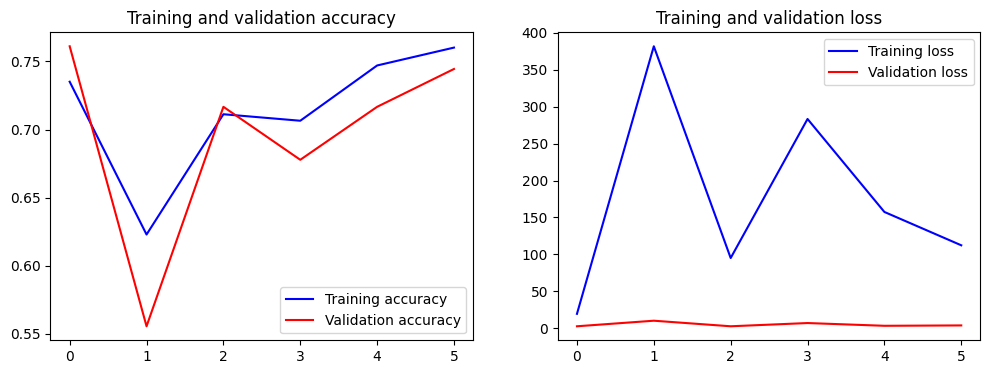

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

In [13]:
# Unfreeze some layers of ResNet50 for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 521ms/step - accuracy: 0.9922 - loss: 0.6808 - val_accuracy: 0.9889 - val_loss: 0.4824
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.9955 - loss: 0.4444 - val_accuracy: 0.9611 - val_loss: 1.0242
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 481ms/step - accuracy: 0.9892 - loss: 8.2211 - val_accuracy: 0.9611 - val_loss: 1.6607
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 478ms/step - accuracy: 0.9724 - loss: 18.2705 - val_accuracy: 0.9611 - val_loss: 12.6858
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.9204 - loss: 24.9710 - val_accuracy: 0.9167 - val_loss: 70.9426


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9839 - loss: 0.4888
Test Accuracy: 0.9777777791023254
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
              precision    recall  f1-score   support

  FreshMango     0.9677    0.9890    0.9783        91
 RottenMango     0.9885    0.9663    0.9773        89

    accuracy                         0.9778       180
   macro avg     0.9781    0.9777    0.9778       180
weighted avg     0.9780    0.9778    0.9778       180



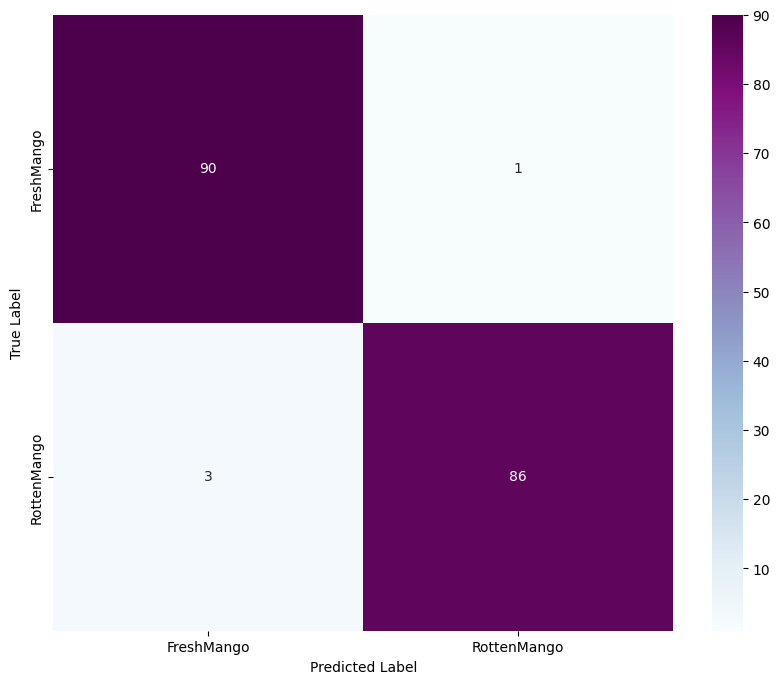

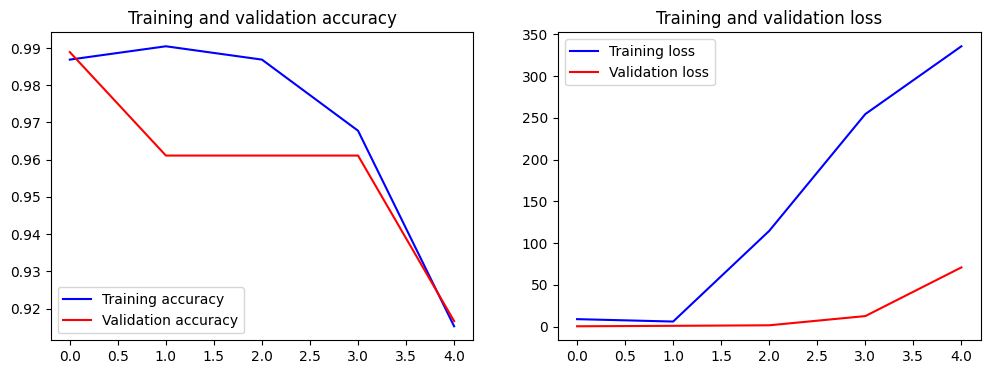

In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# EffecientNet

In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Preprocess input images for EfficientNet
def preprocess_input_efficientnet(x):
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    return x

train_ds = train_ds2.map(lambda x, y: (preprocess_input_efficientnet(x), y))
val_ds = val_ds1.map(lambda x, y: (preprocess_input_efficientnet(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input_efficientnet(x), y))

# Load EfficientNetB7 model with pre-trained ImageNet weights
base_model = EfficientNetB0(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add layers on top of the base model
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes)

# Create the model
model = Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and save history
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8125 - loss: 0.4804 - val_accuracy: 0.9722 - val_loss: 0.1533
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 464ms/step - accuracy: 0.9715 - loss: 0.1713 - val_accuracy: 0.9889 - val_loss: 0.0834
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 460ms/step - accuracy: 0.9910 - loss: 0.0938 - val_accuracy: 0.9889 - val_loss: 0.0574
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 471ms/step - accuracy: 0.9889 - loss: 0.0743 - val_accuracy: 0.9889 - val_loss: 0.0456
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 465ms/step - accuracy: 0.9896 - loss: 0.0649 - val_accuracy: 0.9889 - val_loss: 0.0332
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 470ms/step - accuracy: 0.9926 - loss: 0.0473 - val_accuracy: 0.9889 - val_loss: 0.0309
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 471ms/step - accuracy: 0.9958 - loss: 0.0396 - val_accuracy: 0.9889 - val_loss: 0.0259
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0146
Test Accuracy: 1.0
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
              precision    recall  f1-score   support

  FreshMango     1.0000    1.0000    1.0000        91
 RottenMango     1.0000    1.0000    1.0000        89

    accuracy                         1.0000       180
   macro avg     1.0000    1.0000    1.0000       180
weighted avg     1.0000    1.0000    1.0000       180



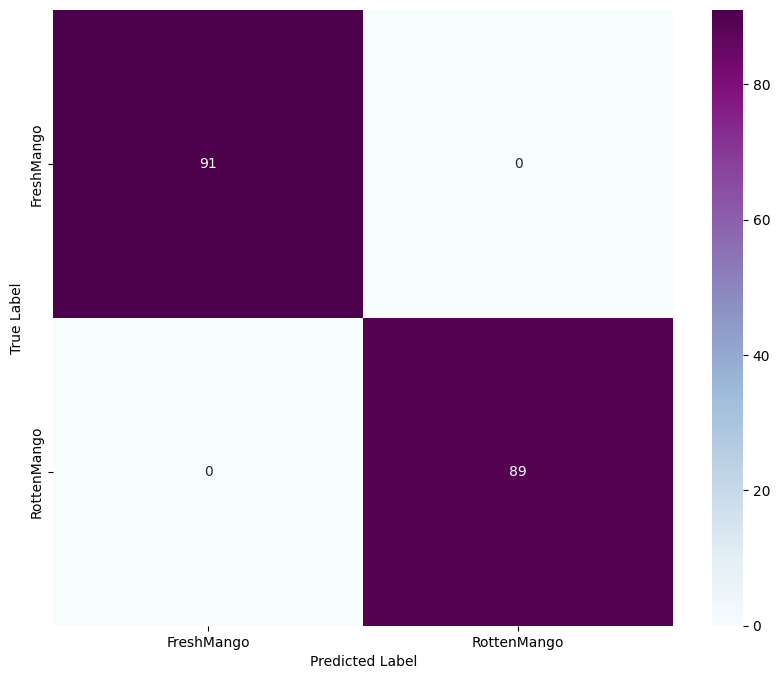

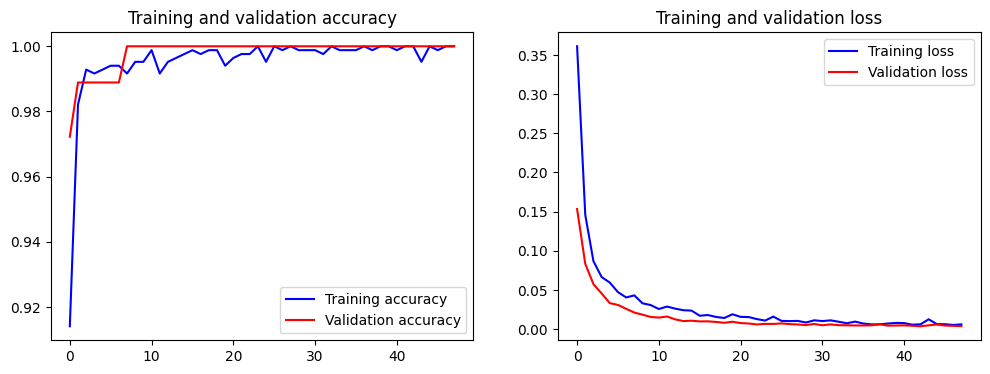

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)